<a href="https://colab.research.google.com/github/saadihamid/Machine-Leaning/blob/main/Neural_Network_Mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
# @title plotting functions

from matplotlib import pyplot as plt
from tqdm import trange

def visualize(images, labels):
    """
    Visualize a batch of images.
    """
    fig, axes = plt.subplots(8, 8, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].squeeze(), cmap='gray')
        ax.set_title(f'Label: {labels[i].item()}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()


def visualize_predictions(images, labels, predicted_labels):
    """
    Visualize a batch of images with their true and predicted labels.
    Titles are green if the prediction is correct, red if incorrect.
    """
    fig, axes = plt.subplots(8, 8, figsize=(11, 12))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].squeeze(), cmap='gray')
        color = 'green' if labels[i].item() == predicted_labels[i].item() else 'red'
        ax.set_title(f'True: {labels[i].item()}\nPred: {predicted_labels[i].item()}', color=color)
        ax.axis('off')

    plt.tight_layout()
    plt.show()


def plot_conf_mat(model, dataloader, device):
    """
    Plot the confusion matrix for a given model and dataloader.
    """
    # Initialize the confusion matrix
    total, correct = 0, 0
    conf_mat = torch.zeros((10, 10))
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            total += pred.shape[0]
            pred = torch.argmax(pred, axis=1)
            correct += sum(pred == y).item()
            for j in range(pred.shape[0]):
                conf_mat[y[j], pred[j].item()] += 1
    # calculate the normalized confusion matrix
    norm_conf_mat = conf_mat / torch.sum(conf_mat, axis=1)
    # plot the matrix
    fig, ax = plt.subplots()
    plt.imshow(norm_conf_mat)
    plt.title('Confusion Matrix')
    plt.xlabel('Predictions')
    plt.ylabel('Labels')
    plt.xticks(range(10))
    plt.yticks(range(10))
    plt.colorbar()
    # put number of each cell in plot
    for i in range(10):
        for j in range(10):
            c = conf_mat[j, i]
            color = 'black' if c > 500 else 'white'
            ax.text(i, j, str(int(c)), va='center', ha='center', color=color)
    plt.show()

def plot_results(train_losses, train_accs, test_losses, test_accs):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    xs = np.arange(1, len(train_losses) + 1, 1)
    axes[0].plot(xs, train_losses, label='Train')
    axes[0].plot(xs, test_losses, label='Test')
    axes[0].set_title('Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_xticks(xs)
    axes[1].plot(xs, train_accs, label='Train')
    axes[1].plot(xs, test_accs, label='Test')
    axes[1].set_title('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_xticks(xs)
    plt.tight_layout()
    plt.legend()
    plt.show()

In [3]:
# Download training data from open datasets.
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)


print(f"Training data: {training_data}\n")
print(f"Test data: {test_data}")

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.83MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 154kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.46MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 1.89MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Training data: Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

Test data: Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [4]:
batch_size = 64

# Create data loaders.
train_loader = DataLoader(training_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

# Iterate over the data
for x, y in test_loader:
    print(f"Shape of X [N, C, H, W]: {x.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


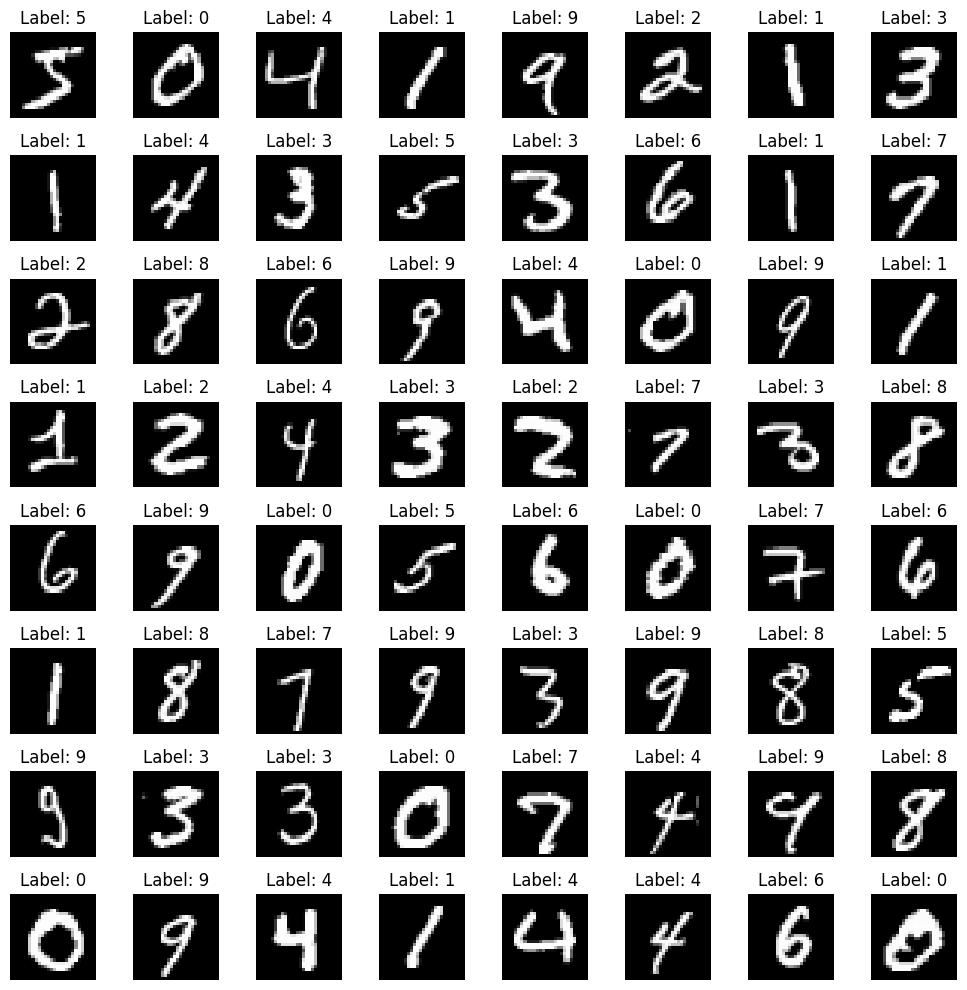

In [5]:
images, labels = next(iter(train_loader))
visualize(images, labels)

In [6]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [7]:
num_classes = len(train_loader.dataset.classes)
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Flatten(), nn.Linear(28*28, 512), nn.BatchNorm1d(512),
            nn.ReLU(), nn.Dropout(0.20), nn.Linear(512, 512), nn.BatchNorm1d(512),
            nn.ReLU(), nn.Dropout(0.20), nn.Linear(512, 512), nn.BatchNorm1d(512),
            nn.ReLU(), nn.Dropout(0.20), nn.Linear(512, 256), nn.BatchNorm1d(256),
            nn.ReLU(), nn.Dropout(0.15), nn.Linear(256, 256), nn.BatchNorm1d(256),
            nn.ReLU(), nn.Dropout(0.15), nn.Linear(256, 256), nn.BatchNorm1d(256),
            nn.ReLU(), nn.Dropout(0.15), nn.Linear(256, 128), nn.BatchNorm1d(128),
            nn.ReLU(), nn.Dropout(0.10), nn.Linear(128, 128), nn.BatchNorm1d(128),
            nn.ReLU(), nn.Dropout(0.10), nn.Linear(128, 128), nn.BatchNorm1d(128),
            nn.ReLU(), nn.Dropout(0.10), nn.Linear(128, 64), nn.BatchNorm1d(64),
            nn.ReLU(), nn.Dropout(0.05), nn.Linear(64, 64), nn.BatchNorm1d(64),
            nn.ReLU(), nn.Dropout(0.05), nn.Linear(64, 64), nn.BatchNorm1d(64),
            nn.ReLU(), nn.Dropout(0.05), nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [8]:
#initialize the model
model = NeuralNetwork().to(device)
#set the optimizer for this model to RMSprop
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-3)
# Number of epochs we wish to train the model
n_epochs = 30

In [9]:
# @title train functions

# for one epoch
def train_step(model, loss_func, optimizer, dataloader, device=device):
    running_loss, correct = 0, 0
    # Move the model to training mode
    model.train()
    # Iterate over the dataloader
    for x, y in dataloader:
        # Move the datapoints to same device as the model
        x, y = x.to(device), y.to(device)
        # Clear the gradients
        optimizer.zero_grad()
        # Predict the output and perform the forward pass
        pred = model(x)
        # Compute prediction error
        loss = loss_func(pred, y)
        # Backpropagation
        loss.backward()
        # Update the model weights
        optimizer.step()
        # Update the running loss
        running_loss += loss.item()
        # Update the correctly predicted counter
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    # Calculate and return the average loss and accuracy
    return running_loss / len(dataloader), 100 * correct / len(dataloader.dataset)

# for one epoch
def test_step(model, loss_func, dataloader, device=device):
    running_loss, correct = 0, 0
    # Move the model to testing mode
    model.eval()
    # Disable gradient calculation
    with torch.no_grad():
      # Iterate over the dataloader
      for x, y in dataloader:
          # Move the datapoints to same device as the model
          x, y = x.to(device), y.to(device)
          # Predict the output and perform the forward pass
          pred = model(x)
          # Update the running loss
          running_loss += loss_func(pred, y).item()
          # Update the correctly predicted counter
          correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    # Calculate and return the average accuracy
    return running_loss / len(dataloader), 100 * correct / len(dataloader.dataset)


def train_model(model, n_epochs, optimizer, train_loader, test_loader, device=device):
    loss_func = nn.CrossEntropyLoss()
    train_losses, train_accs = [], []
    test_losses, test_accs = [], []
    for epoch in (pbar := trange(n_epochs)):
        # Train the model
        train_loss, train_acc = train_step(model, loss_func, optimizer, train_loader, device)
        # Evaluate the model
        test_loss, test_acc = test_step(model, loss_func, test_loader, device)
        # Display the results
        pbar.set_description(f'Train Loss = {train_loss:.3f} | Train Acc = {train_acc:.2f}% | Test Loss = {test_loss:.3f} | Test Acc = {test_acc:.2f}% ')
        # Store the results
        train_losses.append(train_loss), train_accs.append(train_acc), test_losses.append(test_loss), test_accs.append(test_acc)
    return train_losses, train_accs, test_losses, test_accs

In [10]:
# visualize loss and accuracy for different optimizers e.g. SGD, Adam,...
def plot_losses_accurecies(results):
    fig, axes = plt.subplots(1,2)
    for optim, res in results.items():
        if 'losses' not in res or 'accuracies' not in res:
            continue
        losses = res['losses']
        accuracies = res['accuracies']
        axes[0].plot(losses, label = optim)
        axes[1].plot(accuracies, label = optim)
    axes[0].set_title('Losses')
    axes[1].set_title('Accuracies')
    axes[0].legend()
    axes[1].legend()
    fig.set_size_inches(12,6)
    plt.show()


In [11]:
# visualized misclassified images
def visualize_misclassified_images():
    test_data_all = DataLoader(test_data, batch_size=len(test_data.data), shuffle=True)
    images,labels = next(iter(test_data_all))
    print (f"all test data size is {labels.shape[0]}")
    pred = torch.argmax(model[optimizer](images.to(device)), axis=1)
    i = labels != pred
    print(f'mis_classified images in {optimizer} is {np.count_nonzero(i)}')
    print(f'Total Accuracy is: {(labels.shape[0]-np.count_nonzero(i))/labels.shape[0]*100:.2f}% for {optimizer}')
    visualize_predictions(images[i],labels[i],pred[i])


In [12]:
#draw a dropdown list to select an optimizer
import ipywidgets as widget
from IPython.display import display

#Create a list of values
options_optimizers = ['SGD', 'AdaMax', 'RMSProp', 'Adam','RAdam','NAdam']
options_batch_size = [16, 32, 64, 128, 256, 512]
options_n_epochs = [10, 15, 20, 25, 30, 35, 40]
options_lr = [1e-2, 1e-3, 1e-4, 1e-5]
#Create a dropdown widget with custom layout
dropdown_optimizers = widget.Dropdown(
    options = options_optimizers,
    description = 'Optimizer:',
    layout = {'width':'200px', 'height':'30px'},
    style = {'description_width':'100px','description_align':'left','value_align':'right'},
    value = 'RMSProp'
)
dropdown_batch_size = widget.Dropdown(
    options = options_batch_size,
    description = 'Batch Size:',
    layout = {'width':'200px', 'height':'30px'},
    style = {'description_width':'100px','description_align':'left','value_align':'right'},
    value = 64
)
dropdown_n_epoch = widget.Dropdown(
    options = options_n_epochs,
    description = 'N Epochs:',
    layout = {'width':'200px', 'height':'30px'},
    style = {'description_width':'100px','description_align':'left','value_align':'right'},
    value = 10
)
dropdown_lr = widget.Dropdown(
    options = options_lr,
    description = 'Learning Rate:',
    layout = {'width':'200px', 'height':'30px'},
    style = {'description_width':'100px','description_align':'left','value_align':'right'},
    value = 1e-3
)
button_train = widget.Button(
    description = 'Train the Model',
    layout = {'width':'200px', 'height':'30px'},
)
button_plot = widget.Button(
    description = 'Plot the Model',
    layout = {'width':'200px', 'height':'30px'},
)
button_save = widget.Button(
    description = 'Save the Model',
    layout = {'width':'200px', 'height':'30px'},
)
button_load = widget.Button(
    description = 'Load the Model',
    layout = {'width':'200px', 'height':'30px'},
)



label = widget.Label(value="-------------")
top_box = widget.HBox([dropdown_n_epoch,dropdown_batch_size])
mid_box = widget.HBox([dropdown_lr,dropdown_optimizers])
b01_box = widget.HBox([button_train,button_plot])
b02_box = widget.HBox([button_save,button_load])
h_box = widget.VBox([top_box,mid_box,b01_box,b02_box])

n_epochs = dropdown_n_epoch.value
batch_size = dropdown_batch_size.value
optimizer = dropdown_optimizers.value
lr = dropdown_lr.value
model = {'SGD':NeuralNetwork().to(device),
         'AdaMax': NeuralNetwork().to(device),
         'RMSProp': NeuralNetwork().to(device),
         'Adam': NeuralNetwork().to(device),
         'RAdam': NeuralNetwork().to(device),
         'NAdam': NeuralNetwork().to(device),}

#define a funtion to run based on selected value
def batch_size_on_value_change(change):
    global batch_size
    batch_size = dropdown_batch_size.value
#define a funtion to run based on selected value
def n_epochs_size_on_value_change(change):
    global n_epochs
    n_epochs = dropdown_n_epoch.value
#define a funtion to run based on selected value
def optimizer_on_value_change(change):
    global optimizer
    optimizer = dropdown_optimizers.value
#define a funtion to run based on selected value
def lr_on_value_change(change):
    global lr
    lr = dropdown_lr.value
#on clicking the button train
def button_train_on_click(button):
    global first_run,results
    if optimizer == 'SGD':
        opt = torch.optim.SGD(model[optimizer].parameters(), lr=lr)
    elif optimizer == 'AdaMax':
        opt = torch.optim.Adamax(model[optimizer].parameters(), lr=lr)
    elif optimizer == 'RMSProp':
        opt = torch.optim.RMSprop(model[optimizer].parameters(), lr=lr)
    elif optimizer == 'Adam':
        opt = torch.optim.Adam(model[optimizer].parameters(), lr=lr)
    elif optimizer == 'RAdam':
        opt = torch.optim.RAdam(model[optimizer].parameters(), lr=lr)
    elif optimizer == 'NAdam':
        opt = torch.optim.NAdam(model[optimizer].parameters(), lr=lr)

    print (f'\nOptimizer: {optimizer}, Epochs: {n_epochs}, Batch size: {batch_size}, Learning Rate: {lr}')
    train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    global train_losses, train_accuracies, test_losses, test_accuracies
    train_losses, train_accuracies, test_losses, test_accuracies = train_model(model[optimizer],n_epochs,opt,train_loader,test_loader)
    results[optimizer]['losses'] = train_losses
    results[optimizer]['accuracies'] = train_accuracies

def button_plot_on_click(button):
    # Plot the results
    plot_results(train_losses, train_accuracies, test_losses, test_accuracies)
    plot_losses_accurecies(results)
    visualize_misclassified_images()
    plot_conf_mat(model[optimizer],test_loader,device)

def button_save_on_click(button):
    # Save the model
    torch.save(model[optimizer].state_dict(), f'mnist_model_{optimizer}.pth')
    print(f'{optimizer} model is succesfuly saved.')

import os.path
def button_load_on_click(button):
    # Load the model
    if os.path.isfile(f'mnist_model_{optimizer}.pth'):
        model[optimizer].load_state_dict(torch.load(f'mnist_model_{optimizer}.pth', weights_only=True))
        print(f'{optimizer} model is succesfuly loaded.')
    else:
        print(f'You dont have saved model for {optimizer}')
#observe changes in the dropdown value
dropdown_n_epoch.observe(n_epochs_size_on_value_change, names='value')
dropdown_batch_size.observe(batch_size_on_value_change, names='value')
dropdown_optimizers.observe(optimizer_on_value_change, names='value')
dropdown_lr.observe(lr_on_value_change, names='value')
button_train.on_click(button_train_on_click)
button_plot.on_click(button_plot_on_click)
button_save.on_click(button_save_on_click)
button_load.on_click(button_load_on_click)
results = {optim: dict() for optim in options_optimizers}

#display the widget
display(h_box)


Optimizer: RMSProp, Epochs: 40, Batch size: 16, Learning Rate: 0.001


Train Loss = 0.159 | Train Acc = 95.89% | Test Loss = 0.096 | Test Acc = 98.01% :  20%|██        | 8/40 [09:13<37:00, 69.38s/it]